# Face Recognition Demo
- with VGG face extractor
- and CV DNN face detector
- and LFW dataset

In [1]:
%reload_ext autoreload
%autoreload 2

import os
from os.path import join
from glob import glob
from random import randint
from pathlib import Path

import numpy as np
import pandas as pd
import cv2 as cv
%matplotlib inline
import matplotlib.pyplot as plt

import sys
sys.path.append('/work/megapixels_dev/megapixels/')
from app.settings import app_cfg as cfg
from app.settings import types
from app.utils import im_utils, file_utils
from app.models.bbox import BBox
from app.models.data_store import DataStore
from app.processors import face_extractor

In [2]:
data_store = DataStore(types.DataStore.HDD, types.Dataset.LFW)

## Files

In [386]:
fp_records = data_store.metadata(types.Metadata.FILE_RECORD)
df_records = pd.read_csv(fp_records, dtype={'fn':str}).set_index('index')

fp_roi = data_store.metadata(types.Metadata.FACE_ROI)
df_roi = pd.read_csv(fp_roi).set_index('index')

fp_vector = data_store.metadata(types.Metadata.FACE_VECTOR)
df_vector = pd.read_csv(fp_vector).set_index('index')

fp_vector_nj = fp_vector.replace('face_vector.csv', 'face_vector_nj.csv')
df_vector_nj = pd.read_csv(fp_vector_nj, dtype={'fn':str}).set_index('index')

### Load Image

/data_store_hdd/datasets/people/lfw/media/original/Jennifer_Capriati/Jennifer_Capriati_0028.jpg


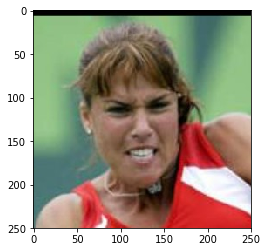

In [445]:
rn = randint(0,len(df_records))
ds_record = df_records.iloc[rn]
fp_im = data_store.face(ds_record.subdir, ds_record.fn, ds_record.ext)
print(fp_im)
im = cv.imread(fp_im)
im_rgb = cv.cvtColor(im, cv.COLOR_BGR2RGB)
plt.imshow(im_rgb)

### Detect Face

- use OpenCV DNN detector

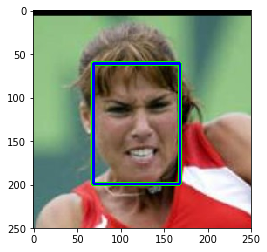

In [446]:
from app.models.bbox import BBox
from app.processors import face_detector
detector = face_detector.DetectorCVDNN()

# get detection as BBox object
bboxes = detector.detect(im, largest=True)
bbox_norm = bboxes[0]
bbox_norm_jit = bbox_norm.jitter(.002)
dim = im.shape[:2][::-1]
bbox_dim = bbox_norm.to_dim(dim)  # convert back to real dimensions
bbox_dim_jit = bbox_norm_jit.to_dim(dim)
# draw detection
dst_rgb = im_rgb.copy()
cv.rectangle(dst_rgb, bbox_dim.pt_tl, bbox_dim.pt_br, (0,255,0), 3)
cv.rectangle(dst_rgb, bbox_dim_jit.pt_tl, bbox_dim_jit.pt_br, (0,0,255), 2)
x1,y1,x2,y2 = bbox_dim.to_xyxy()
im_crop = im[y1:y2,x1:x2]
#plt.imshow(cv.cvtColor(im_crop,cv.COLOR_BGR2RGB))
plt.imshow(dst_rgb)

### Face vectors

- extract feature vector using VGG model

In [447]:
import random
from app.models.bbox import BBox
from app.processors import face_extractor
extractor = face_extractor.ExtractorVGG()

vec_query_nj = extractor.extract_no_jitter(im, bbox_norm)
vec_query_jit = extractor.extract(im, bbox_norm)

### Face match

- find most similar match in the df_vecs

In [448]:
# Takes a while
# convert the CSV to float list of vecs

#vecs_all = [list(map(float, x.vec.split(','))) for x in df_vector.itertuples()]
#vecs_all_nj = [list(map(float, x.vec.split(','))) for x in df_vector_nj.itertuples()]

In [449]:
# convert above to function
def roi_idx_to_image(roi_idx):
  ds_roi = df_roi.iloc[roi_idx]
  record_idx = int(ds_roi.record_index)
  # use the image idx to get the file meta
  ds_record = df_records.iloc[record_idx]
  # construct filepath
  fp_match = data_store.face(ds_record.subdir, ds_record.fn, ds_record.ext)
  im_match = cv.imread(fp_match)
  return im_match  

### Plot match results

best match roi index is 3559 with distance: 0.06165236909409507
match index: 3559, score: 0.06165236909409507
match index: 3546, score: 0.503864071253344
match index: 3551, score: 0.5344297489558646
match index: 3557, score: 0.6297080249912133
match index: 3572, score: 0.7070307164762387
match index: 3539, score: 0.7258128570772926
match index: 3568, score: 0.7313482985444709
match index: 3554, score: 0.7431739992392453
match index: 3553, score: 0.7459584796374285


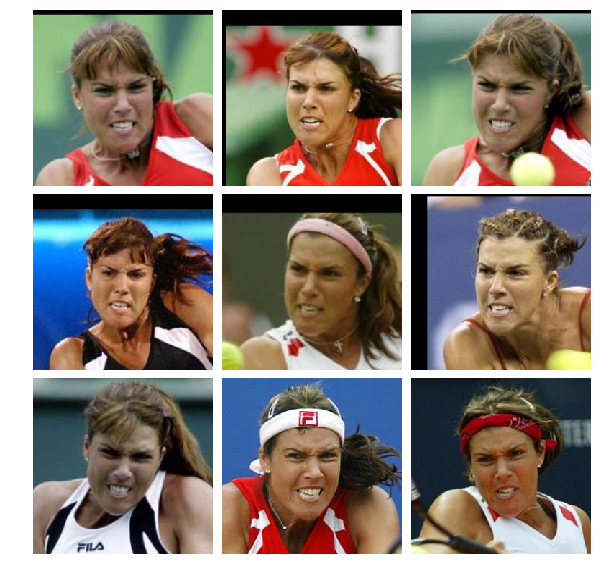

In [450]:
# find similarities using linalg
vecs_sim = np.linalg.norm(np.array([vec_query_jit]) - np.array(vecs_all), axis=1)
# find the best match idx
vec_most_sim = np.argmin(vecs_sim)
print(f'best match roi index is {vec_most_sim} with distance: {vecs_sim[vec_most_sim]}')
# partition the array to get the top 5 roi indices of top 5 matches
nmatches = 9
top_idxs = np.argpartition(vecs_sim, range(nmatches))[:nmatches]
for i in top_idxs:
  print(f'match index: {i}, score: {vecs_sim[i]}')
  
ims = [roi_idx_to_image(x) for x in top_idxs]
max_cols = 3
max_rows = 3
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(10,10))
for idx, im_plt in enumerate(ims[:max_rows*max_cols]):
  row = idx // max_cols
  col = idx % max_cols
  axes[row, col].axis("off")
  im_plt_rgb = cv.cvtColor(im_plt, cv.COLOR_BGR2RGB)
  axes[row, col].imshow(im_plt_rgb, aspect="auto")
plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

best match roi index is 3559 with distance: 0.06323303656986079
match index: 3559, score: 0.06323303656986079
match index: 3546, score: 0.5384970053101156
match index: 3551, score: 0.5506368295111823
match index: 3557, score: 0.622080410233828
match index: 3572, score: 0.7062381476434797
match index: 3539, score: 0.7385290410802864
match index: 3568, score: 0.7450756561503057
match index: 3553, score: 0.7521545532493021
match index: 3573, score: 0.7640029684426967


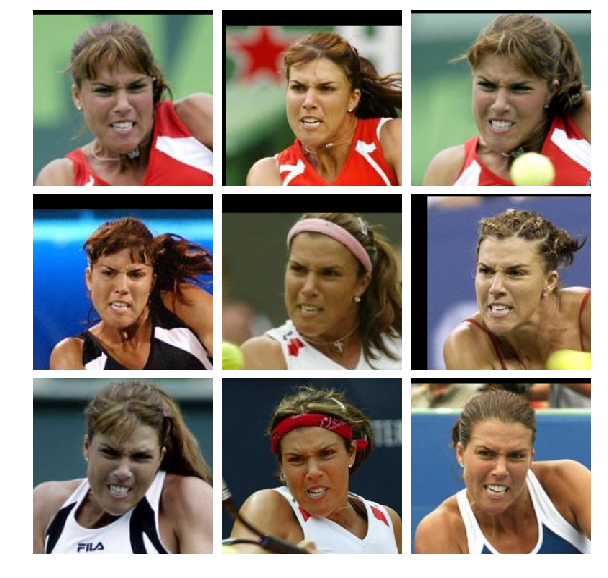

In [451]:
# find similarities using linalg
vecs_sim = np.linalg.norm(np.array([vec_query_nj]) - np.array(vecs_all_nj), axis=1)
# find the best match idx
vec_most_sim = np.argmin(vecs_sim)
print(f'best match roi index is {vec_most_sim} with distance: {vecs_sim[vec_most_sim]}')
# partition the array to get the top 5 roi indices of top 5 matches
nmatches = 9
top_idxs = np.argpartition(vecs_sim, range(nmatches))[:nmatches]
for i in top_idxs:
  print(f'match index: {i}, score: {vecs_sim[i]}')
  
ims = [roi_idx_to_image(x) for x in top_idxs]
max_cols = 3
max_rows = 3
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(10,10))
for idx, im_plt in enumerate(ims[:max_rows*max_cols]):
  row = idx // max_cols
  col = idx % max_cols
  axes[row, col].axis("off")
  im_plt_rgb = cv.cvtColor(im_plt, cv.COLOR_BGR2RGB)
  axes[row, col].imshow(im_plt_rgb, aspect="auto")
plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()